In [1]:
import pandas as pd
import numpy as np
import gemmi
import reciprocalspaceship as rs
from tqdm import tqdm
import glob, os
import matplotlib.pyplot as plt

### 0. Read in ligand log csv

In [3]:
lig_log_path = "./sample_to_smiles_values_only.csv"
lig_log = pd.read_csv(lig_log_path)
DK_bound = lig_log[lig_log["DK hit?"] > 0].copy()
condition_1 = (DK_bound["# Cl atoms"] + DK_bound["# S atoms"] + DK_bound["# I atoms"] + DK_bound["# Br atoms"] + DK_bound["# P atoms"]) >0
condition_2 = DK_bound["Use"] == 1
DK_bound_heavy = DK_bound[condition_1 & condition_2].copy()

## 1. Metric for VAE reconstructed difference maps

### 1.1. Path to necessary files

In [4]:
data_root = "/n/hekstra_lab/people/minhuan/projects/drug/refine_heavy_benchmarks"

pandda_pdb_redindex_root = "/n/hekstra_lab/people/minhuan/projects/drug/minhuan_backup/pipeline/data/bound_models_reindex"
ligand_mapping_csv = "/n/hekstra_lab/people/minhuan/projects/drug/PanDDA/mapping_B_1_LIG_to_DK_PandDA_resi.csv"
lig_mapping = pd.read_csv(ligand_mapping_csv).set_index('dataset')['original DK resi for B/1'].to_dict()

diff_column = "WDF" # or diff
phase_column = "refine_PH2FOFCWT"

### 1.2 Auxilliary functions

In [5]:
def get_heavy_atoms(st, selections='[CL,Br,S,I]'):
    sel = gemmi.Selection(selections)
    sel_model = sel.copy_model_selection(st[0])
    lig_heavy_atoms = [i.atom.clone() for i in list(sel_model.all()) if (i.chain.name == 'B' and i.residue.seqid.num == 1)]
    return lig_heavy_atoms

def get_heavy_atoms_mapping(st, selections='[CL,Br,S,I]', resi=1):
    sel = gemmi.Selection(selections)
    sel_model = sel.copy_model_selection(st[0])
    lig_heavy_atoms = [i.atom.clone() for i in list(sel_model.all()) if (i.chain.name == 'B' and i.residue.seqid.num == resi)]
    return lig_heavy_atoms

def get_peak_values(atom_list, real_grid):
    # check the highest peak
    a,b,c = np.unravel_index(real_grid.array.argmax(), real_grid.array.shape)
    tmp = real_grid.get_fractional(a,b,c)
    peak_pos = mtz.cell.orthogonalize(gemmi.Fractional(tmp.x, tmp.y, tmp.z))
    dis_lists = []
    peak_values = []
    ops = real_grid.spacegroup.operations()
    for atom in atom_list:
        # Get all equivalent sites
        eq_points = []
        dis_list = []
        for op in ops:
            SG_mapped=op.apply_to_xyz(real_grid.unit_cell.fractionalize(atom.pos).tolist())
            tmp = SG_mapped-np.floor(np.array(SG_mapped)) # Move into cell
            SG_mapped = gemmi.Fractional(*tmp)
            # print(f"xyz: {SG_mapped[0]:.3f}, {SG_mapped[1]:.3}, {SG_mapped[2]:.3} ") 
            eq_points.append(SG_mapped)
            SG_mapped_orth = real_grid.unit_cell.orthogonalize(SG_mapped)
            dis_list.append(np.sqrt(np.sum(np.array((peak_pos - SG_mapped_orth).tolist())**2)))
        
        # Get the nearest voxel value
        peak_value = []
        for pos in eq_points:
            a = round(pos.x * real_grid.nu)
            b = round(pos.y * real_grid.nv)
            c = round(pos.z * real_grid.nw)
            peak_value.append(real_grid.get_value(a, b, c))
            #print(real_grid.get_value(a, b, c))
        
        dis_lists.append(dis_list)
        peak_values.append(peak_value)
    return dis_lists, peak_values

### 1.3 production run

In [7]:
peak_log = []
for sample in tqdm(DK_bound_heavy["sample"]):

    initRF_pdb = glob.glob(os.path.join(data_root, f"{sample:04}/PTP1B*.pdb"))[0]
    postRF_pdb = glob.glob(os.path.join(data_root, f"{sample:04}/valdo-small*.pdb"))[0]
    pandda_pdb =  glob.glob(os.path.join(pandda_pdb_redindex_root, f"{sample:04}.pdb"))[0]
    mtz_path =  glob.glob(os.path.join(data_root, f"{sample:04}/*.mtz"))[0]
    
    initRF_model = gemmi.read_pdb(initRF_pdb)
    postRF_model = gemmi.read_pdb(postRF_pdb)
    pandda_model = gemmi.read_pdb(pandda_pdb)
    mtz = gemmi.read_mtz_file(mtz_path)
    real_grid = mtz.transform_f_phi_to_map(diff_column, phase_column, sample_rate=3.0)
    real_grid.normalize()

    initRF_heavy_list = get_heavy_atoms(initRF_model)
    postRF_heavy_list = get_heavy_atoms(postRF_model)
    pandda_heavy_list = get_heavy_atoms_mapping(pandda_model, resi=lig_mapping[sample])

    initRF_dis_lists, initRF_peak_values = get_peak_values(initRF_heavy_list, real_grid)
    postRF_dis_lists, postRF_peak_values = get_peak_values(postRF_heavy_list, real_grid)
    pandda_dis_lists, pandda_peak_values = get_peak_values(pandda_heavy_list, real_grid)

    if sample in [676, 822]:
        initRF_log_peak = np.max(initRF_peak_values, keepdims=True)[0].tolist()
        initRF_log_ismaxpeak = np.any(np.array(initRF_dis_lists) < 5.0, keepdims=True)[0].tolist()
        pandda_log_peak = np.max(pandda_peak_values, keepdims=True)[0].tolist()
        pandda_log_ismaxpeak = np.any(np.array(pandda_dis_lists) < 5.0, keepdims=True)[0].tolist()
    else:
        initRF_log_peak = np.max(initRF_peak_values, axis=1).tolist()
        initRF_log_ismaxpeak = np.any(np.array(initRF_dis_lists) < 5.0, axis=1)
        pandda_log_peak = np.max(pandda_peak_values, axis=1).tolist()
        pandda_log_ismaxpeak = np.any(np.array(pandda_dis_lists) < 5.0, axis=1).tolist()
        
    postRF_log_peak = np.max(postRF_peak_values, axis=1).tolist()
    postRF_log_ismaxpeak = np.any(np.array(postRF_dis_lists) < 5.0, axis=1).tolist()

    for init_atom, post_atom, pandda_atom, init_peak, post_peak, pandda_peak, init_ishighest, post_ishighest, pandda_ishighest in zip(initRF_heavy_list,
                                                                                                                                      postRF_heavy_list,
                                                                                                                                      pandda_heavy_list,
                                                                                                                                      initRF_log_peak, 
                                                                                                                                      postRF_log_peak,
                                                                                                                                      pandda_log_peak,
                                                                                                                                      initRF_log_ismaxpeak, 
                                                                                                                                      postRF_log_ismaxpeak,
                                                                                                                                      pandda_log_ismaxpeak,):
        try:
            assert init_atom.name == post_atom.name
            assert init_atom.name == pandda_atom.name
        except:
            print(sample)
        peak_log.append([sample, init_atom.name, init_peak, post_peak, pandda_peak, init_ishighest, post_ishighest, pandda_ishighest])

100%|██████████| 48/48 [00:11<00:00,  4.34it/s]


In [8]:
vae_peak_df = pd.DataFrame(data=peak_log, columns=["sample", "atom_name", "initRF_peak", "postRF_peak", "pandda_peak", "init_is_highest_peak(<5A)", "post_is_highest_peak(<5A)", "pandda_is_highest_peak(<5A)"])

### 1.4 plot and analysis

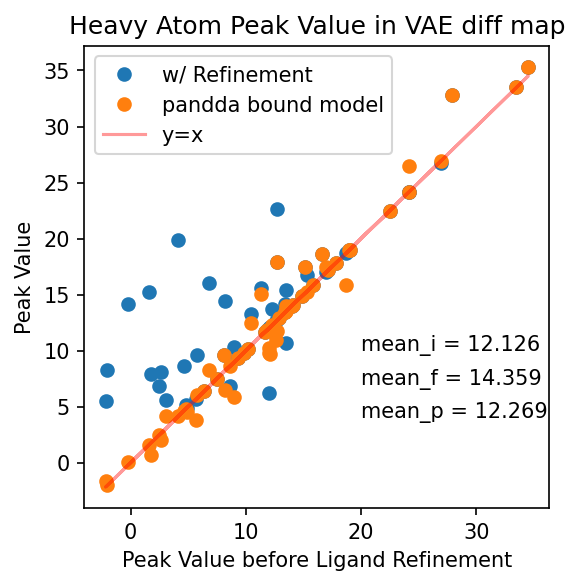

In [9]:
plt.figure(figsize=[4,4], dpi=150)
plt.plot(vae_peak_df["initRF_peak"], vae_peak_df["postRF_peak"], 'o', label="w/ Refinement")
plt.plot(vae_peak_df["initRF_peak"], vae_peak_df["pandda_peak"], 'o', label="pandda bound model")
plt.plot(vae_peak_df["initRF_peak"], vae_peak_df["initRF_peak"], 'r-', alpha=0.4, label='y=x')
plt.xlabel("Peak Value before Ligand Refinement")
plt.ylabel("Peak Value")
plt.legend(loc='upper left')
plt.title("Heavy Atom Peak Value in VAE diff map")
plt.text(20, 10, f"mean_i = {vae_peak_df['initRF_peak'].mean():.3f}")
plt.text(20, 7, f"mean_f = {vae_peak_df['postRF_peak'].mean():.3f}")
plt.text(20, 4, f"mean_p = {vae_peak_df['pandda_peak'].mean():.3f}")
plt.show()

In [10]:
vae_peak_df[vae_peak_df["postRF_peak"] < (vae_peak_df["initRF_peak"]-0.01) ]

,sample,atom_name,initRF_peak,postRF_peak,pandda_peak,init_is_highest_peak(<5A),post_is_highest_peak(<5A),pandda_is_highest_peak(<5A)
31,1009,CL14,11.992602,6.219393,9.764588,True,False,True
33,1043,S04,8.586623,6.864467,8.586623,True,True,True
42,1335,CL09,26.941801,26.717659,26.941801,True,True,True
43,1335,CL11,13.506439,10.686173,13.954219,True,True,True


In [11]:
vae_peak_df[vae_peak_df["sample"]==1009]

,sample,atom_name,initRF_peak,postRF_peak,pandda_peak,init_is_highest_peak(<5A),post_is_highest_peak(<5A),pandda_is_highest_peak(<5A)
30,1009,CL12,5.772454,9.648335,6.008649,True,False,True
31,1009,CL14,11.992602,6.219393,9.764588,True,False,True


In [12]:
vae_peak_df[vae_peak_df["post_is_highest_peak(<5A)"] & ~(vae_peak_df["init_is_highest_peak(<5A)"] ) ]

,sample,atom_name,initRF_peak,postRF_peak,pandda_peak,init_is_highest_peak(<5A),post_is_highest_peak(<5A),pandda_is_highest_peak(<5A)
52,1652,CL07,4.646037,8.647387,4.646037,False,True,False


In [13]:
vae_peak_df[~vae_peak_df["post_is_highest_peak(<5A)"] & (vae_peak_df["init_is_highest_peak(<5A)"] ) ]

,sample,atom_name,initRF_peak,postRF_peak,pandda_peak,init_is_highest_peak(<5A),post_is_highest_peak(<5A),pandda_is_highest_peak(<5A)
30,1009,CL12,5.772454,9.648335,6.008649,True,False,True
31,1009,CL14,11.992602,6.219393,9.764588,True,False,True
34,1136,CL09,-2.030267,8.313408,-2.030267,True,False,True


## 2. Metric for Fo-Fc maps

### 2.1 Path to necessary files

In [14]:
apo_refine_mtz_root = "/n/hekstra_lab/people/minhuan/projects/drug/minhuan_backup/pipeline/data/refined"
diff_column = "FOFCWT" # or diff
phase_column = "PHFOFCWT"

### 2.2 Production run

In [15]:
peak_log = []
for sample in tqdm(DK_bound_heavy["sample"]):
    initRF_pdb = glob.glob(os.path.join(data_root, f"{sample:04}/PTP1B*.pdb"))[0]
    postRF_pdb = glob.glob(os.path.join(data_root, f"{sample:04}/valdo-small*.pdb"))[0]
    pandda_pdb =  glob.glob(os.path.join(pandda_pdb_redindex_root, f"{sample:04}.pdb"))[0]
    mtz_paths =  glob.glob(os.path.join(apo_refine_mtz_root, f"refine_{sample:04}_*.mtz"))
    try:
        assert len(mtz_paths) == 1
    except:
        print(sample)
    mtz_path = mtz_paths[0]
    initRF_model = gemmi.read_pdb(initRF_pdb)
    postRF_model = gemmi.read_pdb(postRF_pdb)
    pandda_model = gemmi.read_pdb(pandda_pdb)
    mtz = gemmi.read_mtz_file(mtz_path)
    real_grid = mtz.transform_f_phi_to_map(diff_column, phase_column, sample_rate=3.0)
    real_grid.normalize()

    initRF_heavy_list = get_heavy_atoms(initRF_model)
    postRF_heavy_list = get_heavy_atoms(postRF_model)
    pandda_heavy_list = get_heavy_atoms_mapping(pandda_model, resi=lig_mapping[sample])

    initRF_dis_lists, initRF_peak_values = get_peak_values(initRF_heavy_list, real_grid)
    postRF_dis_lists, postRF_peak_values = get_peak_values(postRF_heavy_list, real_grid)
    pandda_dis_lists, pandda_peak_values = get_peak_values(pandda_heavy_list, real_grid)

    if sample in [676, 822]:
        initRF_log_peak = np.max(initRF_peak_values, keepdims=True)[0].tolist()
        initRF_log_ismaxpeak = np.any(np.array(initRF_dis_lists) < 5.0, keepdims=True)[0].tolist()
        pandda_log_peak = np.max(pandda_peak_values, keepdims=True)[0].tolist()
        pandda_log_ismaxpeak = np.any(np.array(pandda_dis_lists) < 5.0, keepdims=True)[0].tolist()
    else:
        initRF_log_peak = np.max(initRF_peak_values, axis=1).tolist()
        initRF_log_ismaxpeak = np.any(np.array(initRF_dis_lists) < 5.0, axis=1)
        pandda_log_peak = np.max(pandda_peak_values, axis=1).tolist()
        pandda_log_ismaxpeak = np.any(np.array(pandda_dis_lists) < 5.0, axis=1).tolist()
        
    postRF_log_peak = np.max(postRF_peak_values, axis=1).tolist()
    postRF_log_ismaxpeak = np.any(np.array(postRF_dis_lists) < 5.0, axis=1).tolist()

    for init_atom, post_atom, pandda_atom, init_peak, post_peak, pandda_peak, init_ishighest, post_ishighest, pandda_ishighest in zip(initRF_heavy_list,
                                                                                                                                      postRF_heavy_list,
                                                                                                                                      pandda_heavy_list,
                                                                                                                                      initRF_log_peak, 
                                                                                                                                      postRF_log_peak,
                                                                                                                                      pandda_log_peak,
                                                                                                                                      initRF_log_ismaxpeak, 
                                                                                                                                      postRF_log_ismaxpeak,
                                                                                                                                      pandda_log_ismaxpeak,):
        try:
            assert init_atom.name == post_atom.name
            assert init_atom.name == pandda_atom.name
        except:
            print(sample)
        peak_log.append([sample, init_atom.name, init_peak, post_peak, pandda_peak, init_ishighest, post_ishighest, pandda_ishighest])

100%|██████████| 48/48 [00:11<00:00,  4.27it/s]


In [16]:
FOFC_peak_df = pd.DataFrame(data=peak_log, columns=["sample", "atom_name", "initRF_peak", "postRF_peak", "pandda_peak", "init_is_highest_peak(<5A)", "post_is_highest_peak(<5A)", "pandda_is_highest_peak(<5A)"])

## 3. Metric for PanDDA Zmap 

### 3.1 Path to necessary files

In [17]:
zmap_root = "/n/hekstra_lab/people/minhuan/projects/drug/minhuan_backup/pipeline/data/z_maps"
pandda_bound_states_root = "/n/hekstra_lab/people/minhuan/projects/drug/minhuan_backup/pipeline/data/bound_models_DK"

### 3.2 Define auxilliary functions 

In [18]:
def get_peak_values_zmap(atom_list, real_grid):
    # check the highest peak
    a,b,c = np.unravel_index(real_grid.array.argmax(), real_grid.array.shape)
    tmp = real_grid.get_fractional(a,b,c)
    peak_pos = mtz.cell.orthogonalize(gemmi.Fractional(tmp.z, tmp.y, tmp.x))
    dis_lists = []
    peak_values = []
    ops = real_grid.spacegroup.operations()
    for atom in atom_list:
        # Get all equivalent sites
        eq_points = []
        dis_list = []
        for op in ops:
            SG_mapped=op.apply_to_xyz(real_grid.unit_cell.fractionalize(atom.pos).tolist())
            tmp = SG_mapped-np.floor(np.array(SG_mapped)) # Move into cell
            SG_mapped = gemmi.Fractional(*tmp)
            # print(f"xyz: {SG_mapped[0]:.3f}, {SG_mapped[1]:.3}, {SG_mapped[2]:.3} ") 
            eq_points.append(SG_mapped)
            SG_mapped_orth = real_grid.unit_cell.orthogonalize(SG_mapped)
            dis_list.append(np.sqrt(np.sum(np.array((peak_pos - SG_mapped_orth).tolist())**2)))
        
        # Get the nearest voxel value
        peak_value = []
        for pos in eq_points:
            a = round(pos.z * real_grid.nu)
            b = round(pos.y * real_grid.nv)
            c = round(pos.x * real_grid.nw)
            peak_value.append(real_grid.get_value(a, b, c))
            #print(real_grid.get_value(a, b, c))
        
        dis_lists.append(dis_list)
        peak_values.append(peak_value)
    return dis_lists, peak_values

### 3.3 Production Run

In [38]:
peak_log = []
for sample in tqdm(DK_bound_heavy["sample"]):
    # initRF_pdb = glob.glob(os.path.join(data_root, f"{sample:04}/PTP1B*.pdb"))[0]
    postRF_pdb = glob.glob(os.path.join(data_root, f"{sample:04}/valdo_refine*.pdb"))[0]
    pandda_pdb =  glob.glob(os.path.join(pandda_bound_states_root, f"PTP1B-y{sample:04}_*.pdb"))[0]
    zmap_path =  glob.glob(os.path.join(zmap_root, f"PTP1B-y{sample:04}-*.ccp4"))[0]

    # initRF_model = gemmi.read_pdb(initRF_pdb)
    postRF_model = gemmi.read_pdb(postRF_pdb)
    pandda_model = gemmi.read_pdb(pandda_pdb)
    zmap = gemmi.read_ccp4_map(zmap_path)
    real_grid = zmap.grid
    real_grid.normalize()

    # initRF_heavy_list = get_heavy_atoms(initRF_model)
    postRF_heavy_list = get_heavy_atoms(postRF_model)
    pandda_heavy_list = get_heavy_atoms_mapping(pandda_model, resi=lig_mapping[sample])

    # initRF_dis_lists, initRF_peak_values = get_peak_values_zmap(initRF_heavy_list, real_grid)
    postRF_dis_lists, postRF_peak_values = get_peak_values_zmap(postRF_heavy_list, real_grid)
    pandda_dis_lists, pandda_peak_values = get_peak_values_zmap(pandda_heavy_list, real_grid)

    if sample in [676, 822]:
        # initRF_log_peak = np.max(initRF_peak_values, keepdims=True)[0].tolist()
        # initRF_log_ismaxpeak = np.any(np.array(initRF_dis_lists) < 5.0, keepdims=True)[0].tolist()
        pandda_log_peak = np.max(pandda_peak_values, keepdims=True)[0].tolist()
        pandda_log_ismaxpeak = np.any(np.array(pandda_dis_lists) < 5.0, keepdims=True)[0].tolist()
    else:
        # initRF_log_peak = np.max(initRF_peak_values, axis=1).tolist()
        # initRF_log_ismaxpeak = np.any(np.array(initRF_dis_lists) < 5.0, axis=1)
        pandda_log_peak = np.max(pandda_peak_values, axis=1).tolist()
        pandda_log_ismaxpeak = np.any(np.array(pandda_dis_lists) < 5.0, axis=1).tolist()
    try:  
        postRF_log_peak = np.max(postRF_peak_values, axis=1).tolist()
        postRF_log_ismaxpeak = np.any(np.array(postRF_dis_lists) < 5.0, axis=1).tolist()
    except:
        print(sample)

    for post_atom, pandda_atom, post_peak, pandda_peak, post_ishighest, pandda_ishighest in zip(postRF_heavy_list,
                                                                                                pandda_heavy_list,
                                                                                                postRF_log_peak,
                                                                                                pandda_log_peak,
                                                                                                postRF_log_ismaxpeak,
                                                                                                pandda_log_ismaxpeak,):
        try:
            assert pandda_atom.name == post_atom.name
        except:
            print(sample)
        peak_log.append([sample, pandda_atom.name, post_peak, pandda_peak, post_ishighest, pandda_ishighest])

100%|██████████| 48/48 [00:05<00:00,  8.39it/s]


In [39]:
zmap_peak_df = pd.DataFrame(data=peak_log, columns=["sample", "atom_name", "postRF_peak", "pandda_peak",  "post_is_highest_peak(<5A)", "pandda_is_highest_peak(<5A)"])

## 4. Plots

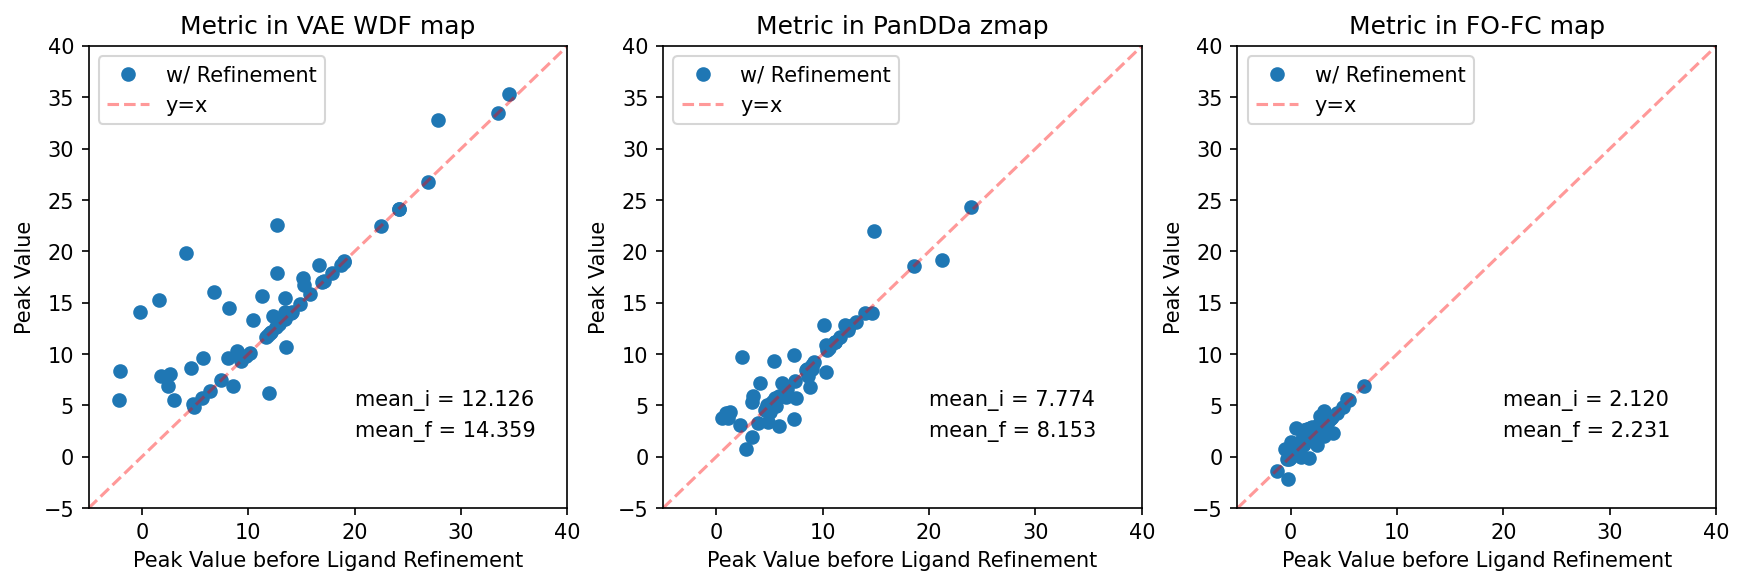

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[14,4], dpi=150)
axs = ax.flatten()
axs[0].plot(vae_peak_df["initRF_peak"], vae_peak_df["postRF_peak"], 'o', label="w/ Refinement")
axs[0].plot([-5,40], [-5,40],'r--', alpha=0.4, label='y=x')
axs[0].set_xlabel("Peak Value before Ligand Refinement")
axs[0].set_ylabel("Peak Value")
axs[0].legend(loc='upper left')
axs[0].set_xlim(-5,40)
axs[0].set_ylim(-5,40)
axs[0].set_title("Metric in VAE WDF map")
axs[0].text(20, 5, f"mean_i = {vae_peak_df['initRF_peak'].mean():.3f}")
axs[0].text(20, 2, f"mean_f = {vae_peak_df['postRF_peak'].mean():.3f}")
#axs[0].text(20, 4, f"mean_p = {vae_peak_df['pandda_peak'].mean():.3f}")

axs[1].plot(zmap_peak_df["pandda_peak"], zmap_peak_df["postRF_peak"], 'o', label="w/ Refinement")
axs[1].plot([-5,40], [-5,40],'r--', alpha=0.4, label='y=x')
axs[1].set_xlabel("Peak Value before Ligand Refinement")
axs[1].set_ylabel("Peak Value")
axs[1].legend(loc='upper left')
axs[1].set_title("Metric in PanDDa zmap")
axs[1].set_xlim(-5,40)
axs[1].set_ylim(-5,40)
axs[1].text(20, 5, f"mean_i = {zmap_peak_df['pandda_peak'].mean():.3f}")
axs[1].text(20, 2, f"mean_f = {zmap_peak_df['postRF_peak'].mean():.3f}")

axs[2].plot(FOFC_peak_df["initRF_peak"], FOFC_peak_df["postRF_peak"], 'o', label="w/ Refinement")
axs[2].plot([-5,40], [-5,40],'r--', alpha=0.4, label='y=x')
axs[2].set_xlabel("Peak Value before Ligand Refinement")
axs[2].set_ylabel("Peak Value")
axs[2].legend(loc='upper left')
axs[2].set_title("Metric in FO-FC map")
axs[2].set_xlim(-5,40)
axs[2].set_ylim(-5,40)
axs[2].text(20, 5, f"mean_i = {FOFC_peak_df['initRF_peak'].mean():.3f}")
axs[2].text(20, 2, f"mean_f = {FOFC_peak_df['postRF_peak'].mean():.3f}")

plt.show()

In [41]:
vae_peak_df.to_csv("./vae_peak_df_pose.csv", index=False)
FOFC_peak_df.to_csv("./FOFC_peak_df_pose.csv", index=False)
zmap_peak_df.to_csv("./zmap_peak_df_pose.csv", index=False)